In [112]:
%pip install matplotlib librosa torch kagglehub
%pip install librosa --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [113]:
import os
import glob
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import re


In [114]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/Andrej/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [115]:
print("music genres in the dataset:", list(os.listdir(f'{path}/Data/genres_original/')))
print("number of music genres:", len(list(os.listdir(f'{path}/Data/genres_original/'))))

music genres in the dataset: ['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
number of music genres: 10


In [116]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
# Initialize a variable to store the minimum length
min_length = float('inf')
number_files = 0

# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                number_files += 1
                # Load the audio file using librosa
                y, sr = librosa.load(file_path)

                # Update the minimum length if needed
                min_length = min(min_length, len(y))

print(f"The minimum length of the music time series across all files is: {min_length}, it's corresponds to a minimum of {min_length/22050} seconds")
print("Number of files:", number_files)

The minimum length of the music time series across all files is: 660000, it's corresponds to a minimum of 29.931972789115648 seconds
Number of files: 999


In [117]:
# Define the directory path
directory = f'{path}/Data/genres_original/'
len_dataset = 0
dataset_filenames = []
# Iterate over all files in the directory
for genre in os.listdir(directory):
    genre_path = os.path.join(directory, genre)

    # Ensure it's a directory
    if os.path.isdir(genre_path):
        for filename in os.listdir(genre_path):
            if filename.endswith('.wav'):
                file_path = os.path.join(genre_path, filename)
                for i in range(min_length//1024):
                    dataset_filenames.append([file_path, i])
print(len(dataset_filenames))

643356


In [118]:
def extract_string(input_str):
    # Regular expression to capture the string between the first two slashes
    match = re.search(r'/([^/]+)/', input_str)
    if match:
        return match.group(1)
    else:
        return None

In [274]:

#################################
# Parameters & Configuration
#################################
AUDIO_DIR = f'{path}/Data/genres_original/'    # Directory containing audio files
SAMPLE_RATE = 22050
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 64     # Frequency bins for the Mel-spectrogram
DURATION = 10.0   # Duration of each audio clip in seconds (30s is the entire clip)
GENRES = ['blues','classical','country','disco','hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']  # Example classes
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps")

# ConvRBM Hyperparameters
VISIBLE_CHANNELS = 1  # Spectrogram is treated as a single "image" channel
HIDDEN_CHANNELS = 16  # Number of convolutional filters
KERNEL_SIZE = (8, 8)
LEARNING_RATE = 1e-3
CD_K = 1    # Contrastive divergence steps
EPOCHS = 1000
BATCH_SIZE = 64


In [275]:
import os
import glob
import numpy as np
import librosa
from torch.utils.data import Dataset, DataLoader
import torch

class AudioDataset(Dataset):
    def __init__(self, audio_dir, genres):
        self.data = []
        self.labels = []
        self._load_audio_files(audio_dir, genres)

    def _load_audio_files(self, audio_dir, genres):
        for i, genre in enumerate(genres):
            genre_path = os.path.join(audio_dir, genre)
            for fname in glob.glob(os.path.join(genre_path, "*.wav")):
                # Load audio
                audio, sr = librosa.load(
                    fname, 
                    sr=SAMPLE_RATE, 
                    duration=DURATION)
                # print("audio length", len(audio))

                # Compute Mel-Spectrogram
                mel_spec = librosa.feature.melspectrogram(
                    y=audio, 
                    sr=SAMPLE_RATE, 
                    n_fft=N_FFT,
                    hop_length=HOP_LENGTH, 
                    n_mels=N_MELS)
                # Convert to log scale
                log_mel = librosa.power_to_db(mel_spec, ref=np.max)
                # Normalize
                log_mel = (log_mel - log_mel.mean()) / (log_mel.std() + 1e-8)

                # Append data and label
                self.data.append(log_mel)
                # print("appending data", log_mel.shape)
                self.labels.append(i)
                # print("appending label", i)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert data and labels to PyTorch tensors
        mel_tensor = torch.tensor(self.data[idx], dtype=torch.float32).unsqueeze(0) # Adding singe channel dimension since it is grayscale
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return mel_tensor, label_tensor

def get_dataloader(audio_dir, genres=GENRES, batch_size=BATCH_SIZE, shuffle=True):
    dataset = AudioDataset(audio_dir, genres)
    return DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [276]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

def split_dataset(audio_dir=AUDIO_DIR, genres=GENRES, test_size=0.1, val_size=0.1, random_seed=14):
    # Create the full dataset
    dataset = AudioDataset(audio_dir, genres)
    print("dataset length", len(dataset))
    
    # Split indices for training, validation, and test sets
    total_size = len(dataset)
    indices = list(range(total_size))
    train_indices, test_indices = train_test_split(
        indices, test_size=test_size, random_state=random_seed)
    
    # Further split the training indices into training and validation
    train_indices, val_indices = train_test_split(
        train_indices, test_size=val_size / (1 - test_size), random_state=random_seed)
    
    # Create subsets
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    return train_subset, val_subset, test_subset

def get_dataloaders(audio_dir, genres=GENRES, batch_size=BATCH_SIZE, test_size=0.1, val_size=0.1, shuffle=True, random_seed=13):
    train_subset, val_subset, test_subset = split_dataset(
        audio_dir, genres, test_size=test_size, val_size=val_size, random_seed=random_seed)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [277]:
train_loader, val_loader, test_loader = get_dataloaders(AUDIO_DIR, GENRES, batch_size=BATCH_SIZE)

dataset length 999


In [278]:
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))



Number of training batches: 13
Number of validation batches: 2
Number of test batches: 2


## ConvRBM

### ConvRBM model

In [279]:
class ConvRBM(nn.Module):
    def __init__(self, visible_channels, hidden_channels, kernel_size=KERNEL_SIZE, learning_rate=1e-3, cd_k=1, batch_size=BATCH_SIZE):
        super(ConvRBM, self).__init__()
        self.visible_channels = visible_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.cd_k = cd_k
        self.batch_size = batch_size  # Add batch_size as an attribute

        # Weights & biases
        self.W = nn.Parameter(torch.randn(hidden_channels, visible_channels, kernel_size[0], kernel_size[1]) * 0.01)
        self.v_bias = nn.Parameter(torch.zeros(1))
        self.h_bias = nn.Parameter(torch.zeros(hidden_channels, 1, 1))  # per hidden channel bias

        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def sample_h(self, v):
        # Convolution to compute hidden probabilities
        # v: [batch, visible_channels, height, width]
        conv_v = nn.functional.conv2d(v, self.W, bias=None)
        # Add hidden bias
        h_lin = conv_v + self.h_bias
        h_prob = torch.sigmoid(h_lin)
        h_sample = torch.bernoulli(h_prob)
        return h_prob, h_sample

    def sample_v(self, h):
        # Transposed convolution to reconstruct visible
        # h: [batch, hidden_channels, h_out, w_out]
        deconv_h = nn.functional.conv_transpose2d(h, self.W, bias=None)
        v_lin = deconv_h + self.v_bias
        v_prob = torch.sigmoid(v_lin)
        v_sample = torch.bernoulli(v_prob)
        return v_prob, v_sample

    def forward(self, v):
        # do a forward pass to get hidden probabilities
        h_prob, _ = self.sample_h(v)
        return h_prob

    # Contrastive Divergence - simplified version with Gibbs sampling
    def contrastive_divergence(self, v):
        # Positive phase
        h_prob, h_sample = self.sample_h(v)

        # Negative phase (Gibbs sampling)
        v_neg = v
        for _ in range(self.cd_k):
            v_prob_neg, v_sample_neg = self.sample_v(h_sample)
            h_prob_neg, h_sample_neg = self.sample_h(v_sample_neg)
            v_neg = v_sample_neg
            h_sample = h_sample_neg

        # Reconstruction loss
        recon_error = torch.mean((v - v_prob_neg) ** 2)

        if self.training:  # Only update weights during training
            self.optimizer.zero_grad()
            recon_error.backward()
            self.optimizer.step()

        return recon_error.item()

    def transform(self, v):
        # Once trained, use hidden probabilities as features
        with torch.no_grad():
            h_prob, _ = self.sample_h(v)
        # Flatten or pool as needed
        # For simplicity, just flatten
        return h_prob.view(h_prob.size(0), -1)
    


    def train_rbm(self, train_loader, val_loader, epochs=10, device='cpu', save_interval=50, save_dir='./model_weights'):
        """Train the RBM on input data using the provided dataloaders for training and testing."""

        train_losses = []  # Store training losses
        val_losses = []   # Store validation losses

        # Retrieve the sizes of training and validation sets
        train_size = len(train_loader.dataset)
        val_size = len(val_loader.dataset)

        print(f"Training set size: {train_size}, Validation set size: {val_size}")

        # Ensure the save directory exists
        os.makedirs(save_dir, exist_ok=True)

        for epoch in range(epochs):
            # Training phase
            self.train()
            train_loss = 0.0

            # Create a progress bar for the training epoch
            with tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training", unit=" batches") as pbar:
                for batch_X, _ in pbar:
                    batch_X = batch_X.to(device)

                    loss = self.contrastive_divergence(batch_X)
                    train_loss += loss

            # Average training loss across all batches
            avg_train_loss = train_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation phase
            self.eval()
            val_loss = 0.0

            with torch.no_grad():
                for batch_X, _ in val_loader:
                    batch_X = batch_X.to(device)

                    loss = self.contrastive_divergence(batch_X)
                    val_loss += loss

            avg_val_loss = val_loss / len(val_loader)
            val_losses.append(avg_val_loss)

            # Logging epoch summary
            print(f"Epoch [{epoch + 1}/{epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

            # Save model weights at intervals
            if (epoch + 1) % save_interval == 0:
                save_path = os.path.join(save_dir, f'rbm_epoch_{epoch + 1}.pth')
                torch.save(self.state_dict(), save_path)
                print(f"Model weights saved to {save_path}")

                # Plot training and validation loss
                plt.figure(figsize=(10, 6))
                plt.plot(range(epoch + 1), train_losses, label='Training Loss')
                plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss Over Epochs')
                plt.legend()
                plt.grid(True)
                plt.show()

                # Plot training and validation loss in log scale
                plt.figure(figsize=(10, 6))
                plt.plot(range(epoch + 1), train_losses, label='Training Loss')
                plt.plot(range(epoch + 1), val_losses, label='Validation Loss')
                plt.yscale('log')
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training and Validation Loss Over Epochs (Log Scale)')
                plt.legend()
                plt.grid(True)
                plt.show()
                


Training set size: 799, Validation set size: 100


Epoch 1/1000 - Training: 100%|██████████| 13/13 [00:04<00:00,  2.84 batches/s]


Epoch [1/1000] - Train Loss: 1.0233, Val Loss: 0.9506


Epoch 2/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.23 batches/s]


Epoch [2/1000] - Train Loss: 0.9357, Val Loss: 0.9086


Epoch 3/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.17 batches/s]


Epoch [3/1000] - Train Loss: 0.8872, Val Loss: 0.8568


Epoch 4/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.63 batches/s]


Epoch [4/1000] - Train Loss: 0.8505, Val Loss: 0.8224


Epoch 5/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.47 batches/s]


Epoch [5/1000] - Train Loss: 0.8123, Val Loss: 0.7827


Epoch 6/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.66 batches/s]


Epoch [6/1000] - Train Loss: 0.7658, Val Loss: 0.7297


Epoch 7/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.53 batches/s]


Epoch [7/1000] - Train Loss: 0.7188, Val Loss: 0.6942


Epoch 8/1000 - Training: 100%|██████████| 13/13 [00:03<00:00,  3.64 batches/s]


Epoch [8/1000] - Train Loss: 0.6953, Val Loss: 0.6822


Epoch 9/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.77 batches/s]


Epoch [9/1000] - Train Loss: 0.6886, Val Loss: 0.6786


Epoch 10/1000 - Training: 100%|██████████| 13/13 [00:03<00:00,  4.21 batches/s]


Epoch [10/1000] - Train Loss: 0.6854, Val Loss: 0.6768


Epoch 11/1000 - Training: 100%|██████████| 13/13 [00:04<00:00,  2.74 batches/s]


Epoch [11/1000] - Train Loss: 0.6838, Val Loss: 0.6757


Epoch 12/1000 - Training: 100%|██████████| 13/13 [00:04<00:00,  3.07 batches/s]


Epoch [12/1000] - Train Loss: 0.6830, Val Loss: 0.6750


Epoch 13/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.04 batches/s]


Epoch [13/1000] - Train Loss: 0.6831, Val Loss: 0.6742


Epoch 14/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.06 batches/s]


Epoch [14/1000] - Train Loss: 0.6815, Val Loss: 0.6737


Epoch 15/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.77 batches/s]


Epoch [15/1000] - Train Loss: 0.6807, Val Loss: 0.6731


Epoch 16/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.66 batches/s]


Epoch [16/1000] - Train Loss: 0.6803, Val Loss: 0.6725


Epoch 17/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.52 batches/s]


Epoch [17/1000] - Train Loss: 0.6804, Val Loss: 0.6720


Epoch 18/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.06 batches/s]


Epoch [18/1000] - Train Loss: 0.6803, Val Loss: 0.6713


Epoch 19/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.25 batches/s]


Epoch [19/1000] - Train Loss: 0.6801, Val Loss: 0.6708


Epoch 20/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.68 batches/s]


Epoch [20/1000] - Train Loss: 0.6791, Val Loss: 0.6703


Epoch 21/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.48 batches/s]


Epoch [21/1000] - Train Loss: 0.6782, Val Loss: 0.6696


Epoch 22/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.82 batches/s]


Epoch [22/1000] - Train Loss: 0.6781, Val Loss: 0.6692


Epoch 23/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.81 batches/s]


Epoch [23/1000] - Train Loss: 0.6775, Val Loss: 0.6685


Epoch 24/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.44 batches/s]


Epoch [24/1000] - Train Loss: 0.6775, Val Loss: 0.6679


Epoch 25/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.65 batches/s]


Epoch [25/1000] - Train Loss: 0.6758, Val Loss: 0.6673
Model weights saved to ./model_weights/rbm_epoch_25.pth


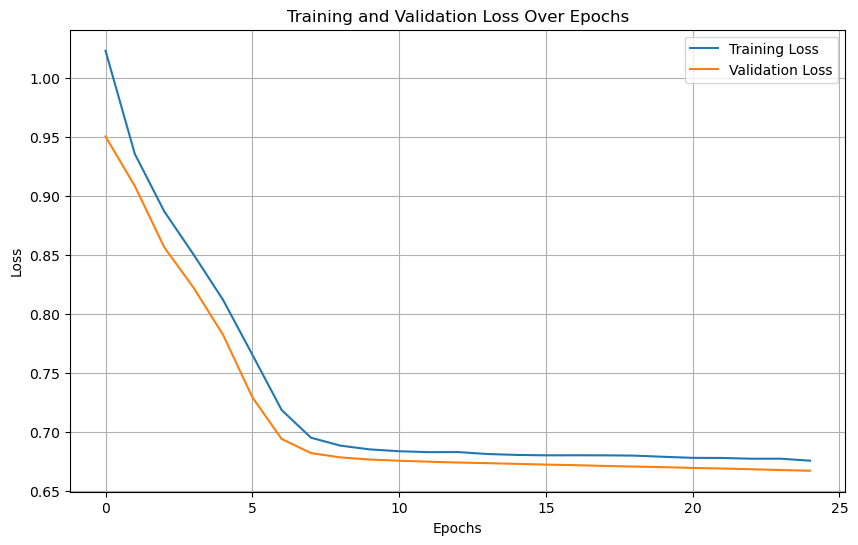

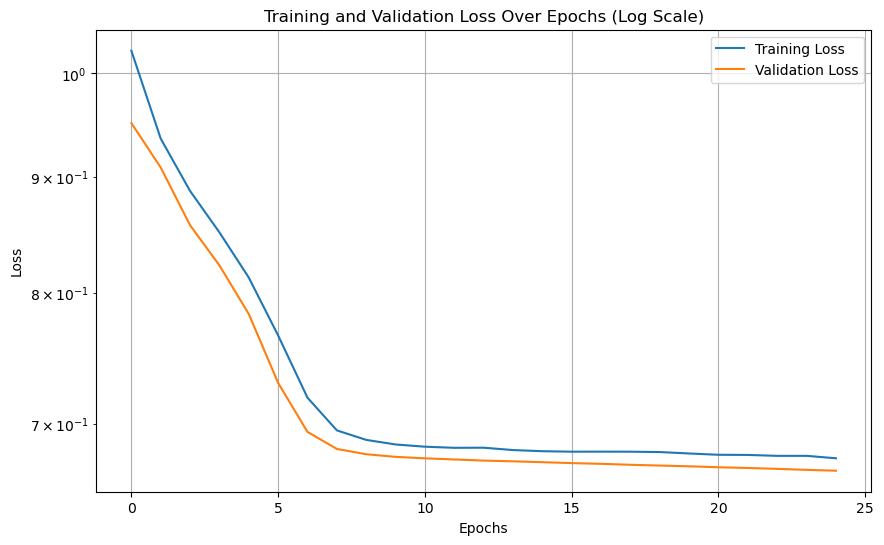

Epoch 26/1000 - Training: 100%|██████████| 13/13 [00:03<00:00,  3.48 batches/s]


Epoch [26/1000] - Train Loss: 0.6751, Val Loss: 0.6667


Epoch 27/1000 - Training: 100%|██████████| 13/13 [00:05<00:00,  2.53 batches/s]


Epoch [27/1000] - Train Loss: 0.6750, Val Loss: 0.6659


Epoch 28/1000 - Training: 100%|██████████| 13/13 [00:03<00:00,  4.21 batches/s]


Epoch [28/1000] - Train Loss: 0.6737, Val Loss: 0.6653


Epoch 29/1000 - Training: 100%|██████████| 13/13 [00:04<00:00,  2.93 batches/s]


Epoch [29/1000] - Train Loss: 0.6725, Val Loss: 0.6645


Epoch 30/1000 - Training: 100%|██████████| 13/13 [00:03<00:00,  3.72 batches/s]


Epoch [30/1000] - Train Loss: 0.6722, Val Loss: 0.6639


Epoch 31/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.36 batches/s]


Epoch [31/1000] - Train Loss: 0.6723, Val Loss: 0.6630


Epoch 32/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.80 batches/s]


Epoch [32/1000] - Train Loss: 0.6711, Val Loss: 0.6622


Epoch 33/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.79 batches/s]


Epoch [33/1000] - Train Loss: 0.6697, Val Loss: 0.6614


Epoch 34/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.67 batches/s]


Epoch [34/1000] - Train Loss: 0.6697, Val Loss: 0.6604


Epoch 35/1000 - Training: 100%|██████████| 13/13 [00:05<00:00,  2.20 batches/s]


Epoch [35/1000] - Train Loss: 0.6679, Val Loss: 0.6596


Epoch 36/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.39 batches/s]


Epoch [36/1000] - Train Loss: 0.6672, Val Loss: 0.6586


Epoch 37/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.65 batches/s]


Epoch [37/1000] - Train Loss: 0.6671, Val Loss: 0.6575


Epoch 38/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.91 batches/s]


Epoch [38/1000] - Train Loss: 0.6659, Val Loss: 0.6567


Epoch 39/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.43 batches/s]


Epoch [39/1000] - Train Loss: 0.6640, Val Loss: 0.6556


Epoch 40/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.38 batches/s]


Epoch [40/1000] - Train Loss: 0.6639, Val Loss: 0.6546


Epoch 41/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.83 batches/s]


Epoch [41/1000] - Train Loss: 0.6624, Val Loss: 0.6535


Epoch 42/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.91 batches/s]


Epoch [42/1000] - Train Loss: 0.6615, Val Loss: 0.6523


Epoch 43/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.03 batches/s]


Epoch [43/1000] - Train Loss: 0.6610, Val Loss: 0.6514


Epoch 44/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [44/1000] - Train Loss: 0.6598, Val Loss: 0.6503


Epoch 45/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.72 batches/s]


Epoch [45/1000] - Train Loss: 0.6580, Val Loss: 0.6492


Epoch 46/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.75 batches/s]


Epoch [46/1000] - Train Loss: 0.6577, Val Loss: 0.6483


Epoch 47/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.82 batches/s]


Epoch [47/1000] - Train Loss: 0.6561, Val Loss: 0.6473


Epoch 48/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.76 batches/s]


Epoch [48/1000] - Train Loss: 0.6554, Val Loss: 0.6464


Epoch 49/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.50 batches/s]


Epoch [49/1000] - Train Loss: 0.6543, Val Loss: 0.6456


Epoch 50/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  4.55 batches/s]


Epoch [50/1000] - Train Loss: 0.6538, Val Loss: 0.6447
Model weights saved to ./model_weights/rbm_epoch_50.pth


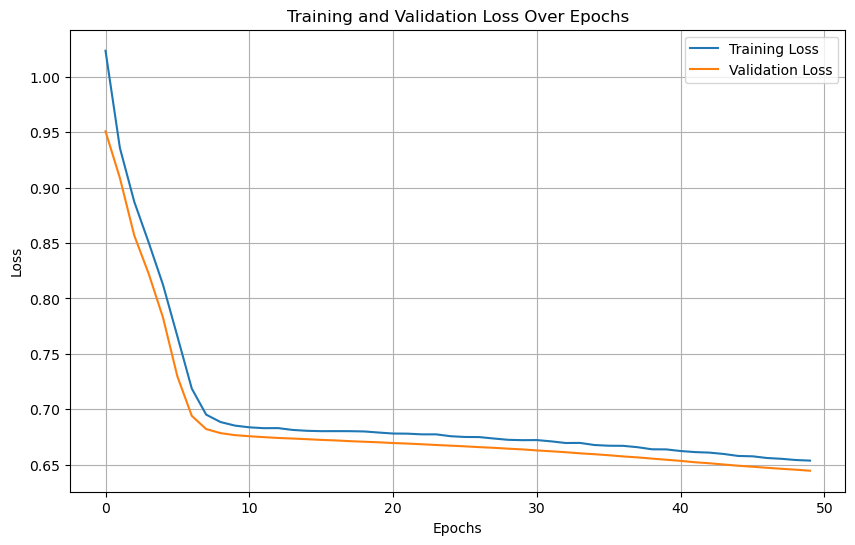

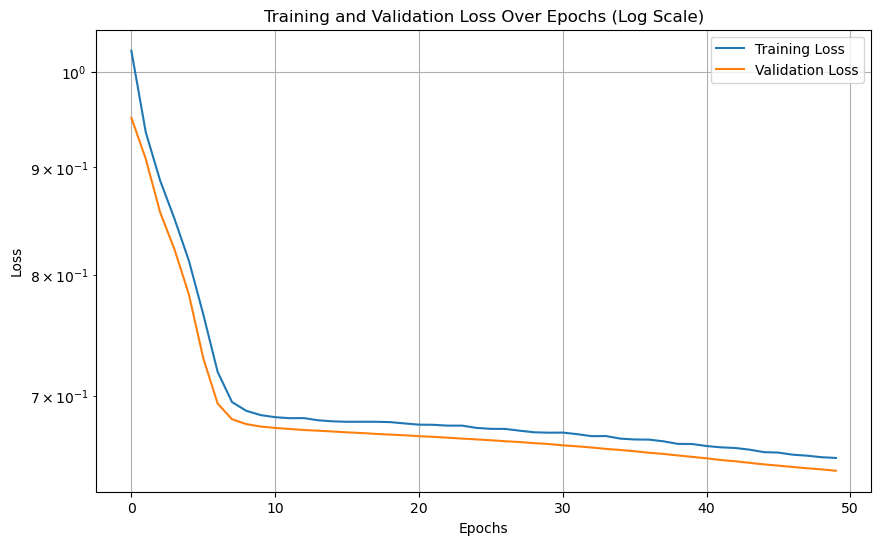

Epoch 51/1000 - Training: 100%|██████████| 13/13 [00:03<00:00,  3.48 batches/s]


Epoch [51/1000] - Train Loss: 0.6533, Val Loss: 0.6440


Epoch 52/1000 - Training: 100%|██████████| 13/13 [00:03<00:00,  4.13 batches/s]


Epoch [52/1000] - Train Loss: 0.6523, Val Loss: 0.6432


Epoch 53/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.87 batches/s]


Epoch [53/1000] - Train Loss: 0.6517, Val Loss: 0.6426


Epoch 54/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.81 batches/s]


Epoch [54/1000] - Train Loss: 0.6506, Val Loss: 0.6421


Epoch 55/1000 - Training: 100%|██████████| 13/13 [00:05<00:00,  2.56 batches/s]


Epoch [55/1000] - Train Loss: 0.6506, Val Loss: 0.6416


Epoch 56/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.57 batches/s]


Epoch [56/1000] - Train Loss: 0.6501, Val Loss: 0.6410


Epoch 57/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.13 batches/s]


Epoch [57/1000] - Train Loss: 0.6499, Val Loss: 0.6406


Epoch 58/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.66 batches/s]


Epoch [58/1000] - Train Loss: 0.6488, Val Loss: 0.6401


Epoch 59/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.17 batches/s]


Epoch [59/1000] - Train Loss: 0.6485, Val Loss: 0.6397


Epoch 60/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.58 batches/s]


Epoch [60/1000] - Train Loss: 0.6479, Val Loss: 0.6394


Epoch 61/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.43 batches/s]


Epoch [61/1000] - Train Loss: 0.6470, Val Loss: 0.6391


Epoch 62/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.31 batches/s]


Epoch [62/1000] - Train Loss: 0.6477, Val Loss: 0.6388


Epoch 63/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.60 batches/s]


Epoch [63/1000] - Train Loss: 0.6469, Val Loss: 0.6385


Epoch 64/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.26 batches/s]


Epoch [64/1000] - Train Loss: 0.6463, Val Loss: 0.6383


Epoch 65/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.54 batches/s]


Epoch [65/1000] - Train Loss: 0.6469, Val Loss: 0.6379


Epoch 66/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [66/1000] - Train Loss: 0.6463, Val Loss: 0.6377


Epoch 67/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.34 batches/s]


Epoch [67/1000] - Train Loss: 0.6460, Val Loss: 0.6375


Epoch 68/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.97 batches/s]


Epoch [68/1000] - Train Loss: 0.6453, Val Loss: 0.6373


Epoch 69/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.73 batches/s]


Epoch [69/1000] - Train Loss: 0.6455, Val Loss: 0.6370


Epoch 70/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.59 batches/s]


Epoch [70/1000] - Train Loss: 0.6460, Val Loss: 0.6369


Epoch 71/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.88 batches/s]


Epoch [71/1000] - Train Loss: 0.6450, Val Loss: 0.6366


Epoch 72/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.06 batches/s]


Epoch [72/1000] - Train Loss: 0.6454, Val Loss: 0.6364


Epoch 73/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.64 batches/s]


Epoch [73/1000] - Train Loss: 0.6444, Val Loss: 0.6362


Epoch 74/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.21 batches/s]


Epoch [74/1000] - Train Loss: 0.6442, Val Loss: 0.6359


Epoch 75/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.72 batches/s]


Epoch [75/1000] - Train Loss: 0.6442, Val Loss: 0.6358
Model weights saved to ./model_weights/rbm_epoch_75.pth


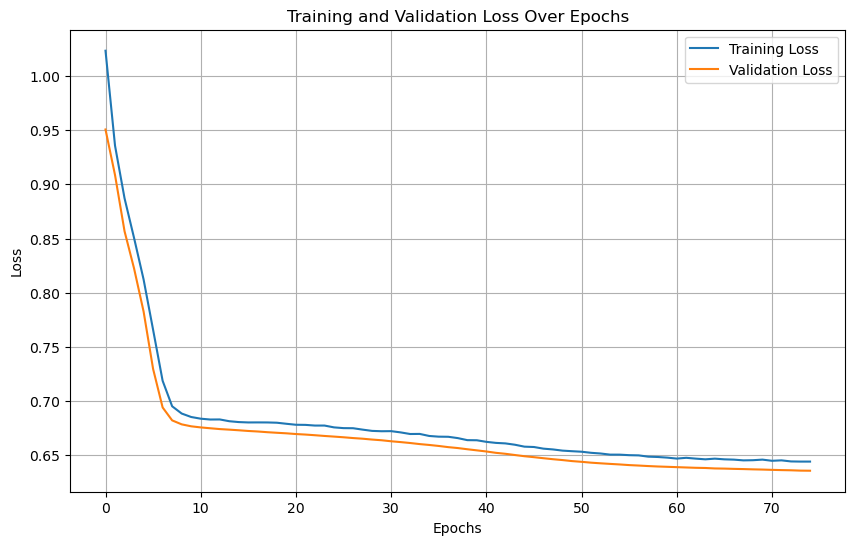

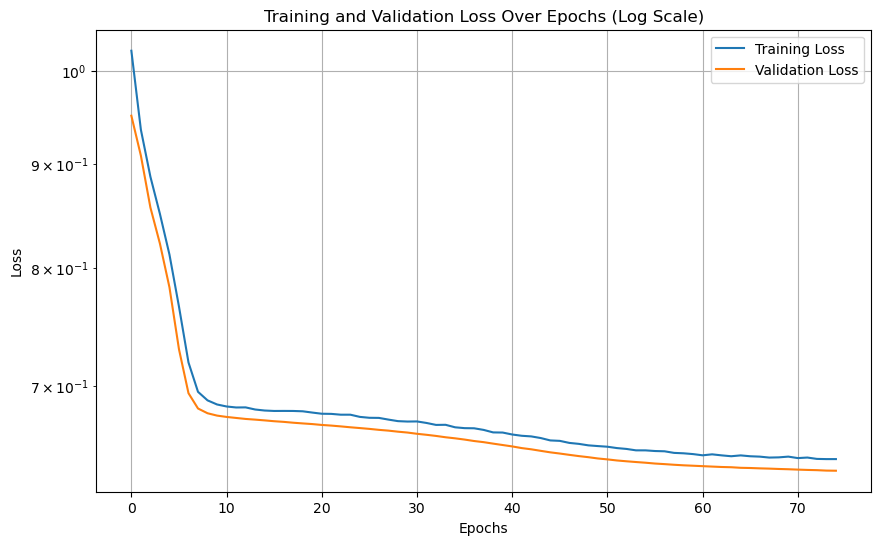

Epoch 76/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.77 batches/s]


Epoch [76/1000] - Train Loss: 0.6440, Val Loss: 0.6356


Epoch 77/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.18 batches/s]


Epoch [77/1000] - Train Loss: 0.6434, Val Loss: 0.6354


Epoch 78/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.79 batches/s]


Epoch [78/1000] - Train Loss: 0.6440, Val Loss: 0.6353


Epoch 79/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.11 batches/s]


Epoch [79/1000] - Train Loss: 0.6431, Val Loss: 0.6350


Epoch 80/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.12 batches/s]


Epoch [80/1000] - Train Loss: 0.6433, Val Loss: 0.6348


Epoch 81/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.50 batches/s]


Epoch [81/1000] - Train Loss: 0.6433, Val Loss: 0.6345


Epoch 82/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.08 batches/s]


Epoch [82/1000] - Train Loss: 0.6430, Val Loss: 0.6344


Epoch 83/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.37 batches/s]


Epoch [83/1000] - Train Loss: 0.6423, Val Loss: 0.6342


Epoch 84/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.51 batches/s]


Epoch [84/1000] - Train Loss: 0.6422, Val Loss: 0.6340


Epoch 85/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.82 batches/s]


Epoch [85/1000] - Train Loss: 0.6424, Val Loss: 0.6338


Epoch 86/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.33 batches/s]


Epoch [86/1000] - Train Loss: 0.6419, Val Loss: 0.6336


Epoch 87/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.11 batches/s]


Epoch [87/1000] - Train Loss: 0.6413, Val Loss: 0.6335


Epoch 88/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [88/1000] - Train Loss: 0.6411, Val Loss: 0.6332


Epoch 89/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.23 batches/s]


Epoch [89/1000] - Train Loss: 0.6417, Val Loss: 0.6330


Epoch 90/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.03 batches/s]


Epoch [90/1000] - Train Loss: 0.6410, Val Loss: 0.6329


Epoch 91/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [91/1000] - Train Loss: 0.6416, Val Loss: 0.6327


Epoch 92/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.51 batches/s]


Epoch [92/1000] - Train Loss: 0.6409, Val Loss: 0.6324


Epoch 93/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.09 batches/s]


Epoch [93/1000] - Train Loss: 0.6409, Val Loss: 0.6323


Epoch 94/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.38 batches/s]


Epoch [94/1000] - Train Loss: 0.6403, Val Loss: 0.6321


Epoch 95/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.43 batches/s]


Epoch [95/1000] - Train Loss: 0.6403, Val Loss: 0.6320


Epoch 96/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.51 batches/s]


Epoch [96/1000] - Train Loss: 0.6406, Val Loss: 0.6319


Epoch 97/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.00 batches/s]


Epoch [97/1000] - Train Loss: 0.6400, Val Loss: 0.6317


Epoch 98/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.37 batches/s]


Epoch [98/1000] - Train Loss: 0.6399, Val Loss: 0.6316


Epoch 99/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.31 batches/s]


Epoch [99/1000] - Train Loss: 0.6397, Val Loss: 0.6314


Epoch 100/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.17 batches/s]


Epoch [100/1000] - Train Loss: 0.6391, Val Loss: 0.6311
Model weights saved to ./model_weights/rbm_epoch_100.pth


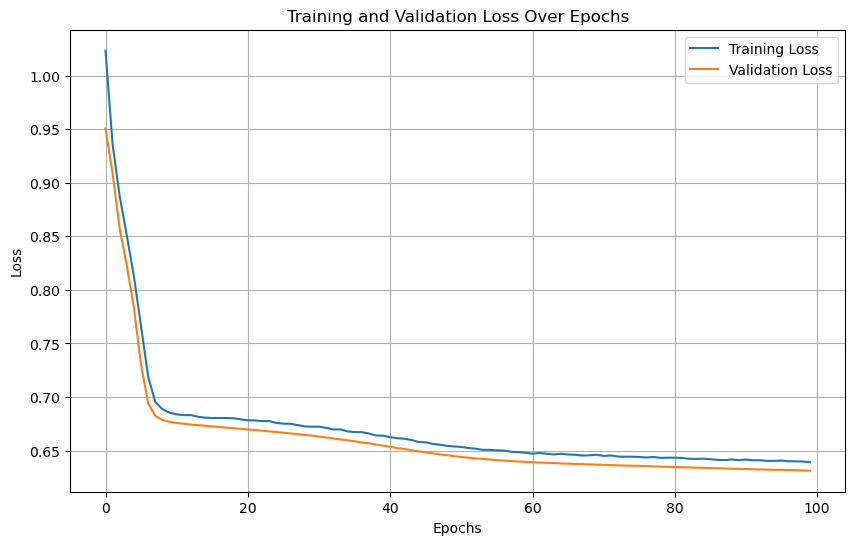

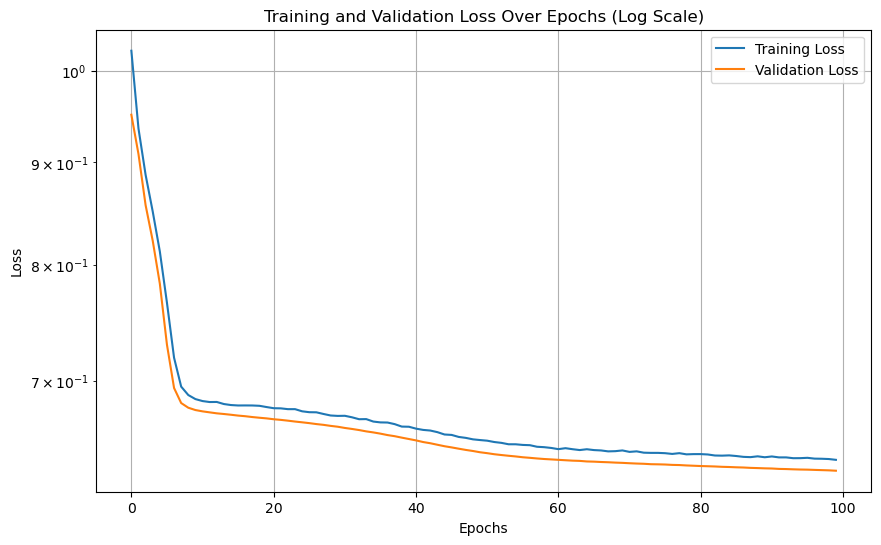

Epoch 101/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.66 batches/s]


Epoch [101/1000] - Train Loss: 0.6391, Val Loss: 0.6311


Epoch 102/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.93 batches/s]


Epoch [102/1000] - Train Loss: 0.6392, Val Loss: 0.6309


Epoch 103/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.69 batches/s]


Epoch [103/1000] - Train Loss: 0.6389, Val Loss: 0.6308


Epoch 104/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.13 batches/s]


Epoch [104/1000] - Train Loss: 0.6389, Val Loss: 0.6306


Epoch 105/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.05 batches/s]


Epoch [105/1000] - Train Loss: 0.6387, Val Loss: 0.6304


Epoch 106/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.80 batches/s]


Epoch [106/1000] - Train Loss: 0.6382, Val Loss: 0.6303


Epoch 107/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.36 batches/s]


Epoch [107/1000] - Train Loss: 0.6387, Val Loss: 0.6301


Epoch 108/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.03 batches/s]


Epoch [108/1000] - Train Loss: 0.6384, Val Loss: 0.6300


Epoch 109/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.39 batches/s]


Epoch [109/1000] - Train Loss: 0.6376, Val Loss: 0.6299


Epoch 110/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.27 batches/s]


Epoch [110/1000] - Train Loss: 0.6377, Val Loss: 0.6297


Epoch 111/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.84 batches/s]


Epoch [111/1000] - Train Loss: 0.6381, Val Loss: 0.6295


Epoch 112/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.36 batches/s]


Epoch [112/1000] - Train Loss: 0.6373, Val Loss: 0.6294


Epoch 113/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.38 batches/s]


Epoch [113/1000] - Train Loss: 0.6380, Val Loss: 0.6294


Epoch 114/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.20 batches/s]


Epoch [114/1000] - Train Loss: 0.6375, Val Loss: 0.6293


Epoch 115/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.22 batches/s]


Epoch [115/1000] - Train Loss: 0.6367, Val Loss: 0.6291


Epoch 116/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [116/1000] - Train Loss: 0.6366, Val Loss: 0.6290


Epoch 117/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.21 batches/s]


Epoch [117/1000] - Train Loss: 0.6368, Val Loss: 0.6289


Epoch 118/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.27 batches/s]


Epoch [118/1000] - Train Loss: 0.6375, Val Loss: 0.6287


Epoch 119/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.22 batches/s]


Epoch [119/1000] - Train Loss: 0.6371, Val Loss: 0.6286


Epoch 120/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.30 batches/s]


Epoch [120/1000] - Train Loss: 0.6372, Val Loss: 0.6285


Epoch 121/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.33 batches/s]


Epoch [121/1000] - Train Loss: 0.6361, Val Loss: 0.6284


Epoch 122/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.46 batches/s]


Epoch [122/1000] - Train Loss: 0.6361, Val Loss: 0.6283


Epoch 123/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.13 batches/s]


Epoch [123/1000] - Train Loss: 0.6362, Val Loss: 0.6282


Epoch 124/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.30 batches/s]


Epoch [124/1000] - Train Loss: 0.6353, Val Loss: 0.6281


Epoch 125/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.05 batches/s]


Epoch [125/1000] - Train Loss: 0.6352, Val Loss: 0.6280
Model weights saved to ./model_weights/rbm_epoch_125.pth


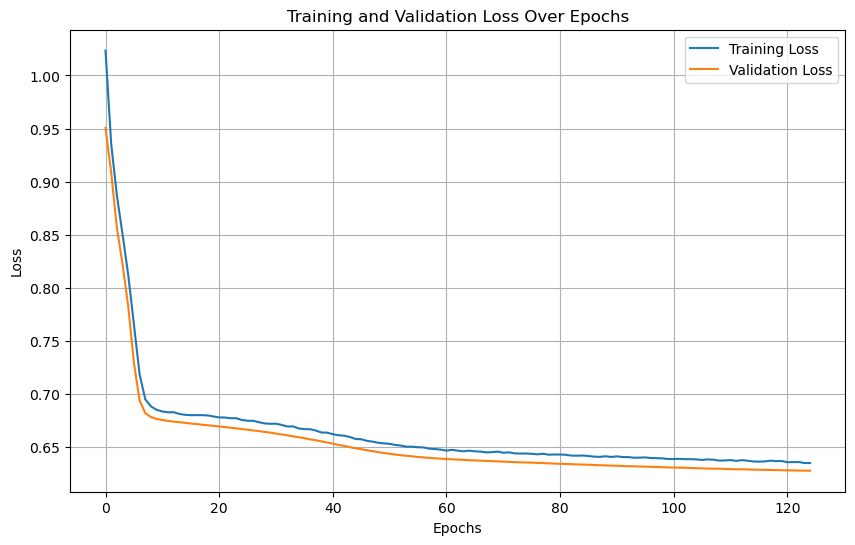

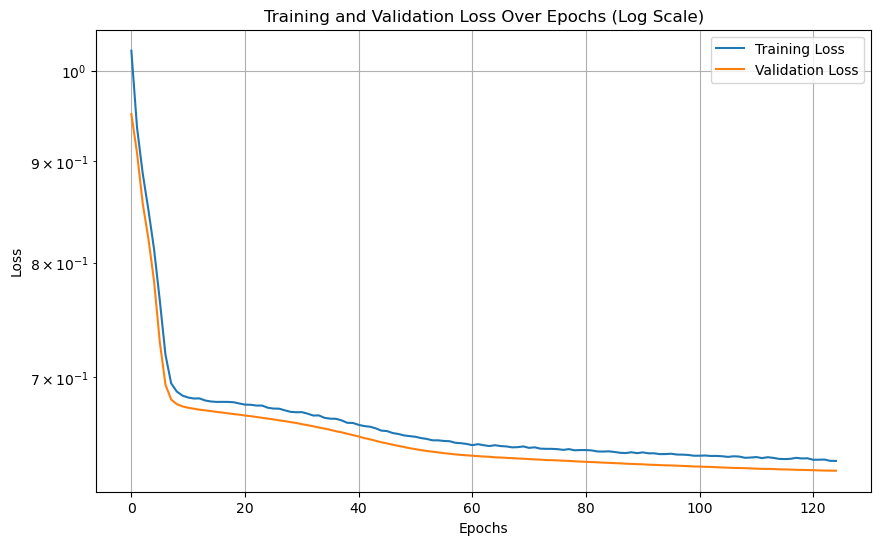

Epoch 126/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.95 batches/s]


Epoch [126/1000] - Train Loss: 0.6364, Val Loss: 0.6278


Epoch 127/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [127/1000] - Train Loss: 0.6357, Val Loss: 0.6278


Epoch 128/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.32 batches/s]


Epoch [128/1000] - Train Loss: 0.6355, Val Loss: 0.6277


Epoch 129/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [129/1000] - Train Loss: 0.6354, Val Loss: 0.6276


Epoch 130/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.85 batches/s]


Epoch [130/1000] - Train Loss: 0.6358, Val Loss: 0.6274


Epoch 131/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.74 batches/s]


Epoch [131/1000] - Train Loss: 0.6356, Val Loss: 0.6274


Epoch 132/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.15 batches/s]


Epoch [132/1000] - Train Loss: 0.6353, Val Loss: 0.6273


Epoch 133/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.80 batches/s]


Epoch [133/1000] - Train Loss: 0.6350, Val Loss: 0.6272


Epoch 134/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.36 batches/s]


Epoch [134/1000] - Train Loss: 0.6357, Val Loss: 0.6272


Epoch 135/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.39 batches/s]


Epoch [135/1000] - Train Loss: 0.6354, Val Loss: 0.6271


Epoch 136/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.30 batches/s]


Epoch [136/1000] - Train Loss: 0.6346, Val Loss: 0.6269


Epoch 137/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.35 batches/s]


Epoch [137/1000] - Train Loss: 0.6349, Val Loss: 0.6270


Epoch 138/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.76 batches/s]


Epoch [138/1000] - Train Loss: 0.6357, Val Loss: 0.6268


Epoch 139/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.05 batches/s]


Epoch [139/1000] - Train Loss: 0.6346, Val Loss: 0.6267


Epoch 140/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.42 batches/s]


Epoch [140/1000] - Train Loss: 0.6344, Val Loss: 0.6267


Epoch 141/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.36 batches/s]


Epoch [141/1000] - Train Loss: 0.6339, Val Loss: 0.6266


Epoch 142/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.50 batches/s]


Epoch [142/1000] - Train Loss: 0.6347, Val Loss: 0.6264


Epoch 143/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.28 batches/s]


Epoch [143/1000] - Train Loss: 0.6337, Val Loss: 0.6264


Epoch 144/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [144/1000] - Train Loss: 0.6346, Val Loss: 0.6263


Epoch 145/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.53 batches/s]


Epoch [145/1000] - Train Loss: 0.6338, Val Loss: 0.6262


Epoch 146/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.64 batches/s]


Epoch [146/1000] - Train Loss: 0.6340, Val Loss: 0.6261


Epoch 147/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.08 batches/s]


Epoch [147/1000] - Train Loss: 0.6337, Val Loss: 0.6261


Epoch 148/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.97 batches/s]


Epoch [148/1000] - Train Loss: 0.6340, Val Loss: 0.6260


Epoch 149/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.63 batches/s]


Epoch [149/1000] - Train Loss: 0.6338, Val Loss: 0.6259


Epoch 150/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.60 batches/s]


Epoch [150/1000] - Train Loss: 0.6330, Val Loss: 0.6258
Model weights saved to ./model_weights/rbm_epoch_150.pth


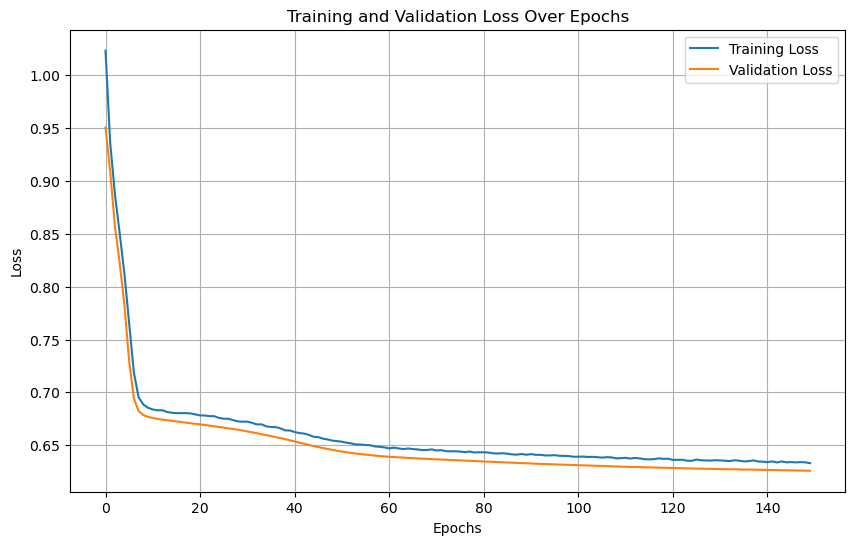

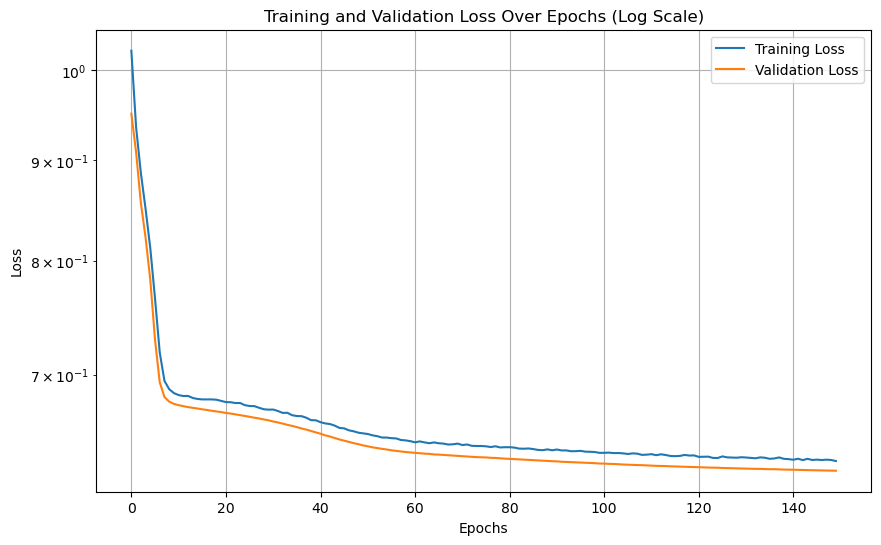

Epoch 151/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.22 batches/s]


Epoch [151/1000] - Train Loss: 0.6333, Val Loss: 0.6258


Epoch 152/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.76 batches/s]


Epoch [152/1000] - Train Loss: 0.6340, Val Loss: 0.6257


Epoch 153/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.73 batches/s]


Epoch [153/1000] - Train Loss: 0.6341, Val Loss: 0.6256


Epoch 154/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.99 batches/s]


Epoch [154/1000] - Train Loss: 0.6328, Val Loss: 0.6256


Epoch 155/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.34 batches/s]


Epoch [155/1000] - Train Loss: 0.6336, Val Loss: 0.6254


Epoch 156/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.68 batches/s]


Epoch [156/1000] - Train Loss: 0.6331, Val Loss: 0.6254


Epoch 157/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.37 batches/s]


Epoch [157/1000] - Train Loss: 0.6323, Val Loss: 0.6252


Epoch 158/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.29 batches/s]


Epoch [158/1000] - Train Loss: 0.6330, Val Loss: 0.6253


Epoch 159/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.62 batches/s]


Epoch [159/1000] - Train Loss: 0.6331, Val Loss: 0.6251


Epoch 160/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.98 batches/s]


Epoch [160/1000] - Train Loss: 0.6320, Val Loss: 0.6252


Epoch 161/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.05 batches/s]


Epoch [161/1000] - Train Loss: 0.6321, Val Loss: 0.6249


Epoch 162/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.31 batches/s]


Epoch [162/1000] - Train Loss: 0.6329, Val Loss: 0.6250


Epoch 163/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.27 batches/s]


Epoch [163/1000] - Train Loss: 0.6330, Val Loss: 0.6249


Epoch 164/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.80 batches/s]


Epoch [164/1000] - Train Loss: 0.6327, Val Loss: 0.6248


Epoch 165/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.89 batches/s]


Epoch [165/1000] - Train Loss: 0.6329, Val Loss: 0.6247


Epoch 166/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [166/1000] - Train Loss: 0.6319, Val Loss: 0.6247


Epoch 167/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [167/1000] - Train Loss: 0.6317, Val Loss: 0.6245


Epoch 168/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.38 batches/s]


Epoch [168/1000] - Train Loss: 0.6317, Val Loss: 0.6245


Epoch 169/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [169/1000] - Train Loss: 0.6324, Val Loss: 0.6245


Epoch 170/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.99 batches/s]


Epoch [170/1000] - Train Loss: 0.6323, Val Loss: 0.6244


Epoch 171/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.39 batches/s]


Epoch [171/1000] - Train Loss: 0.6315, Val Loss: 0.6243


Epoch 172/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.23 batches/s]


Epoch [172/1000] - Train Loss: 0.6314, Val Loss: 0.6244


Epoch 173/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [173/1000] - Train Loss: 0.6322, Val Loss: 0.6242


Epoch 174/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.35 batches/s]


Epoch [174/1000] - Train Loss: 0.6317, Val Loss: 0.6242


Epoch 175/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.32 batches/s]


Epoch [175/1000] - Train Loss: 0.6315, Val Loss: 0.6242
Model weights saved to ./model_weights/rbm_epoch_175.pth


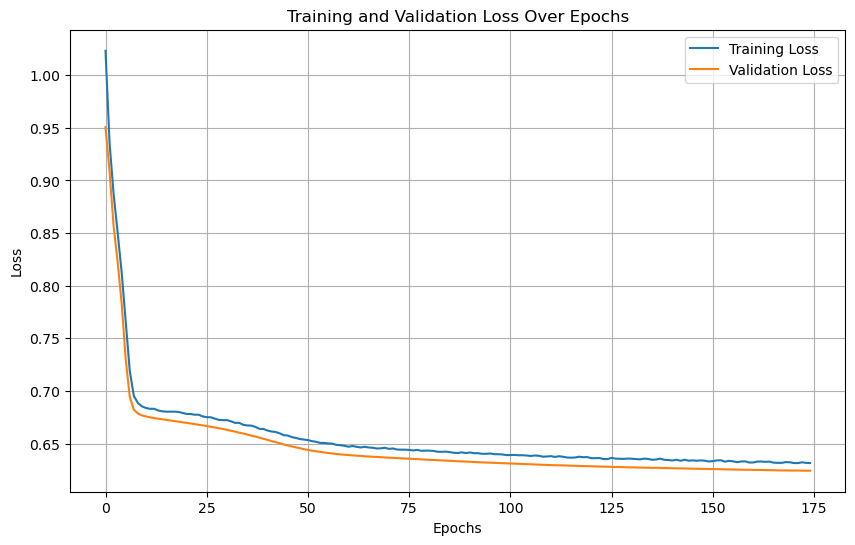

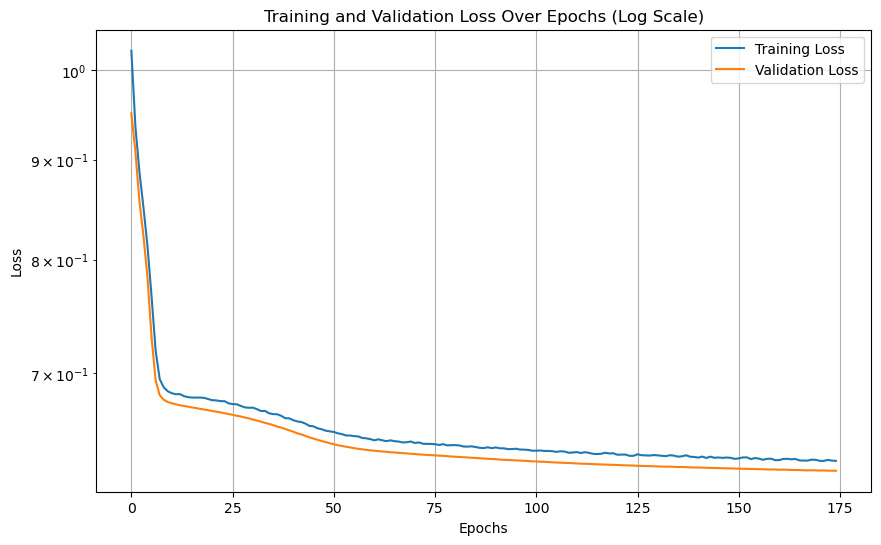

Epoch 176/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.93 batches/s]


Epoch [176/1000] - Train Loss: 0.6313, Val Loss: 0.6241


Epoch 177/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.90 batches/s]


Epoch [177/1000] - Train Loss: 0.6314, Val Loss: 0.6240


Epoch 178/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.94 batches/s]


Epoch [178/1000] - Train Loss: 0.6314, Val Loss: 0.6240


Epoch 179/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.05 batches/s]


Epoch [179/1000] - Train Loss: 0.6314, Val Loss: 0.6239


Epoch 180/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.97 batches/s]


Epoch [180/1000] - Train Loss: 0.6311, Val Loss: 0.6238


Epoch 181/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.38 batches/s]


Epoch [181/1000] - Train Loss: 0.6312, Val Loss: 0.6239


Epoch 182/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.37 batches/s]


Epoch [182/1000] - Train Loss: 0.6314, Val Loss: 0.6237


Epoch 183/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.91 batches/s]


Epoch [183/1000] - Train Loss: 0.6309, Val Loss: 0.6237


Epoch 184/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.36 batches/s]


Epoch [184/1000] - Train Loss: 0.6312, Val Loss: 0.6236


Epoch 185/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.95 batches/s]


Epoch [185/1000] - Train Loss: 0.6312, Val Loss: 0.6236


Epoch 186/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.57 batches/s]


Epoch [186/1000] - Train Loss: 0.6310, Val Loss: 0.6235


Epoch 187/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.20 batches/s]


Epoch [187/1000] - Train Loss: 0.6313, Val Loss: 0.6235


Epoch 188/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.21 batches/s]


Epoch [188/1000] - Train Loss: 0.6308, Val Loss: 0.6234


Epoch 189/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.29 batches/s]


Epoch [189/1000] - Train Loss: 0.6316, Val Loss: 0.6234


Epoch 190/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.51 batches/s]


Epoch [190/1000] - Train Loss: 0.6307, Val Loss: 0.6234


Epoch 191/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.29 batches/s]


Epoch [191/1000] - Train Loss: 0.6303, Val Loss: 0.6233


Epoch 192/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [192/1000] - Train Loss: 0.6308, Val Loss: 0.6233


Epoch 193/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.34 batches/s]


Epoch [193/1000] - Train Loss: 0.6305, Val Loss: 0.6232


Epoch 194/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.39 batches/s]


Epoch [194/1000] - Train Loss: 0.6308, Val Loss: 0.6232


Epoch 195/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.14 batches/s]


Epoch [195/1000] - Train Loss: 0.6303, Val Loss: 0.6232


Epoch 196/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.40 batches/s]


Epoch [196/1000] - Train Loss: 0.6309, Val Loss: 0.6231


Epoch 197/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.42 batches/s]


Epoch [197/1000] - Train Loss: 0.6304, Val Loss: 0.6231


Epoch 198/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.59 batches/s]


Epoch [198/1000] - Train Loss: 0.6305, Val Loss: 0.6231


Epoch 199/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.96 batches/s]


Epoch [199/1000] - Train Loss: 0.6303, Val Loss: 0.6230


Epoch 200/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.98 batches/s]


Epoch [200/1000] - Train Loss: 0.6316, Val Loss: 0.6230
Model weights saved to ./model_weights/rbm_epoch_200.pth


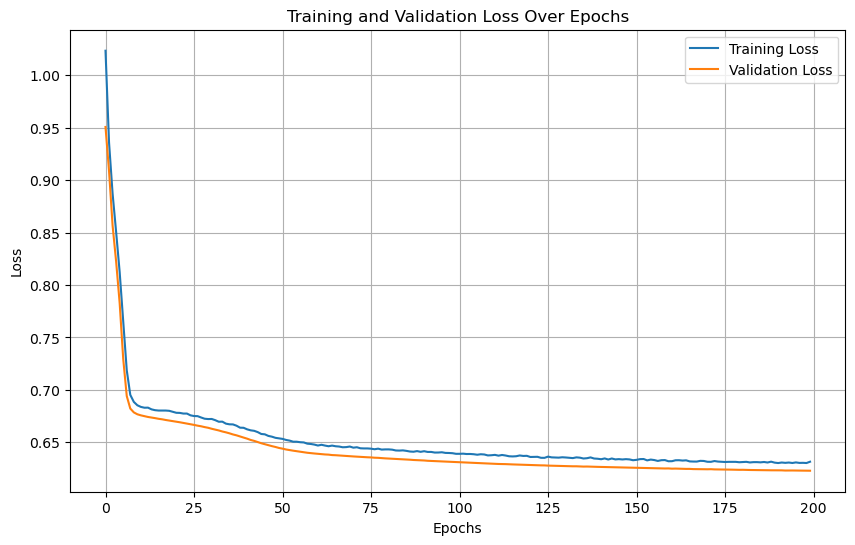

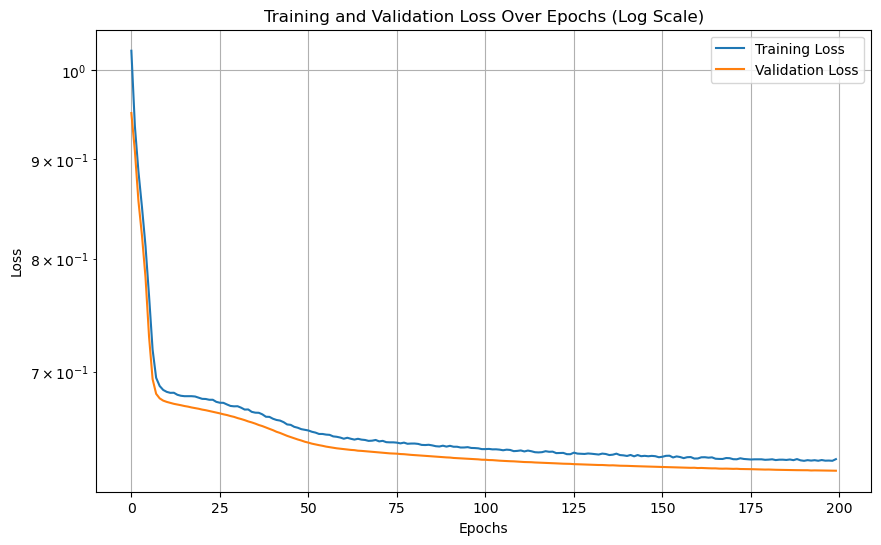

Epoch 201/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.52 batches/s]


Epoch [201/1000] - Train Loss: 0.6305, Val Loss: 0.6229


Epoch 202/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.90 batches/s]


Epoch [202/1000] - Train Loss: 0.6299, Val Loss: 0.6229


Epoch 203/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.96 batches/s]


Epoch [203/1000] - Train Loss: 0.6302, Val Loss: 0.6229


Epoch 204/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.69 batches/s]


Epoch [204/1000] - Train Loss: 0.6304, Val Loss: 0.6228


Epoch 205/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [205/1000] - Train Loss: 0.6297, Val Loss: 0.6228


Epoch 206/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.21 batches/s]


Epoch [206/1000] - Train Loss: 0.6299, Val Loss: 0.6227


Epoch 207/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.70 batches/s]


Epoch [207/1000] - Train Loss: 0.6306, Val Loss: 0.6228


Epoch 208/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.29 batches/s]


Epoch [208/1000] - Train Loss: 0.6300, Val Loss: 0.6227


Epoch 209/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.38 batches/s]


Epoch [209/1000] - Train Loss: 0.6295, Val Loss: 0.6226


Epoch 210/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.35 batches/s]


Epoch [210/1000] - Train Loss: 0.6305, Val Loss: 0.6226


Epoch 211/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.31 batches/s]


Epoch [211/1000] - Train Loss: 0.6303, Val Loss: 0.6226


Epoch 212/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.13 batches/s]


Epoch [212/1000] - Train Loss: 0.6297, Val Loss: 0.6226


Epoch 213/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.92 batches/s]


Epoch [213/1000] - Train Loss: 0.6301, Val Loss: 0.6225


Epoch 214/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.36 batches/s]


Epoch [214/1000] - Train Loss: 0.6308, Val Loss: 0.6225


Epoch 215/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.20 batches/s]


Epoch [215/1000] - Train Loss: 0.6303, Val Loss: 0.6224


Epoch 216/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.33 batches/s]


Epoch [216/1000] - Train Loss: 0.6292, Val Loss: 0.6225


Epoch 217/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.44 batches/s]


Epoch [217/1000] - Train Loss: 0.6304, Val Loss: 0.6224


Epoch 218/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.04 batches/s]


Epoch [218/1000] - Train Loss: 0.6295, Val Loss: 0.6224


Epoch 219/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.13 batches/s]


Epoch [219/1000] - Train Loss: 0.6299, Val Loss: 0.6223


Epoch 220/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.10 batches/s]


Epoch [220/1000] - Train Loss: 0.6299, Val Loss: 0.6224


Epoch 221/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.40 batches/s]


Epoch [221/1000] - Train Loss: 0.6295, Val Loss: 0.6222


Epoch 222/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.35 batches/s]


Epoch [222/1000] - Train Loss: 0.6287, Val Loss: 0.6222


Epoch 223/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.14 batches/s]


Epoch [223/1000] - Train Loss: 0.6293, Val Loss: 0.6222


Epoch 224/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.19 batches/s]


Epoch [224/1000] - Train Loss: 0.6290, Val Loss: 0.6222


Epoch 225/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.20 batches/s]


Epoch [225/1000] - Train Loss: 0.6298, Val Loss: 0.6223
Model weights saved to ./model_weights/rbm_epoch_225.pth


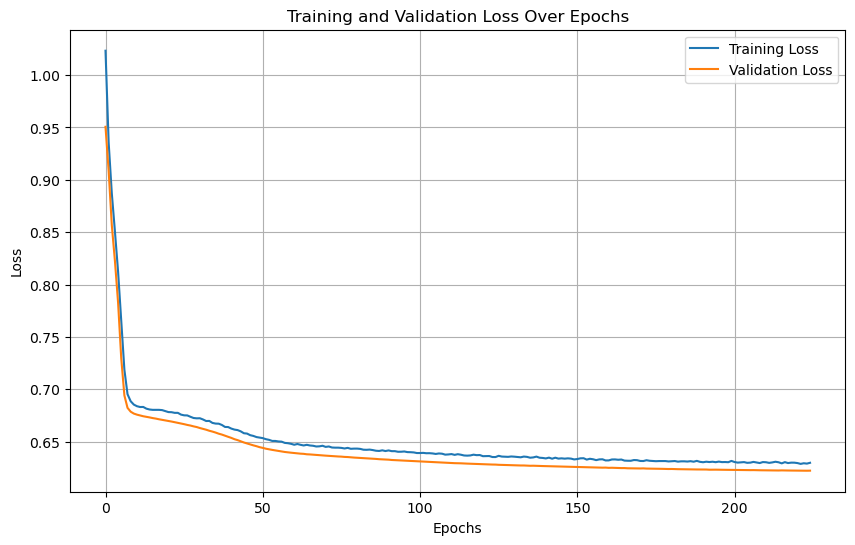

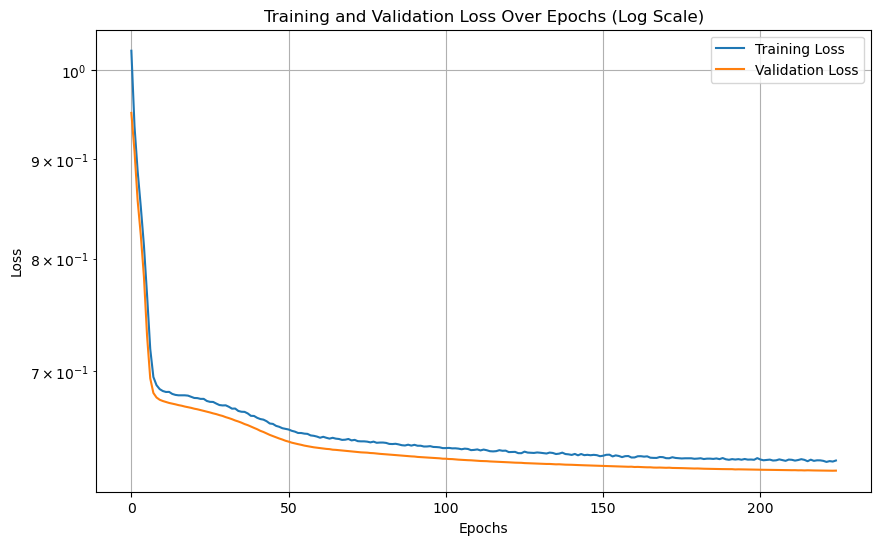

Epoch 226/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.47 batches/s]


Epoch [226/1000] - Train Loss: 0.6298, Val Loss: 0.6222


Epoch 227/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.30 batches/s]


Epoch [227/1000] - Train Loss: 0.6297, Val Loss: 0.6221


Epoch 228/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.63 batches/s]


Epoch [228/1000] - Train Loss: 0.6296, Val Loss: 0.6222


Epoch 229/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.98 batches/s]


Epoch [229/1000] - Train Loss: 0.6299, Val Loss: 0.6221


Epoch 230/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.69 batches/s]


Epoch [230/1000] - Train Loss: 0.6300, Val Loss: 0.6221


Epoch 231/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.40 batches/s]


Epoch [231/1000] - Train Loss: 0.6295, Val Loss: 0.6221


Epoch 232/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.09 batches/s]


Epoch [232/1000] - Train Loss: 0.6294, Val Loss: 0.6221


Epoch 233/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.94 batches/s]


Epoch [233/1000] - Train Loss: 0.6294, Val Loss: 0.6221


Epoch 234/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.38 batches/s]


Epoch [234/1000] - Train Loss: 0.6294, Val Loss: 0.6220


Epoch 235/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.09 batches/s]


Epoch [235/1000] - Train Loss: 0.6299, Val Loss: 0.6220


Epoch 236/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.18 batches/s]


Epoch [236/1000] - Train Loss: 0.6286, Val Loss: 0.6219


Epoch 237/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.10 batches/s]


Epoch [237/1000] - Train Loss: 0.6290, Val Loss: 0.6219


Epoch 238/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.98 batches/s]


Epoch [238/1000] - Train Loss: 0.6291, Val Loss: 0.6219


Epoch 239/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.50 batches/s]


Epoch [239/1000] - Train Loss: 0.6296, Val Loss: 0.6219


Epoch 240/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.41 batches/s]


Epoch [240/1000] - Train Loss: 0.6294, Val Loss: 0.6219


Epoch 241/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.01 batches/s]


Epoch [241/1000] - Train Loss: 0.6293, Val Loss: 0.6219


Epoch 242/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.47 batches/s]


Epoch [242/1000] - Train Loss: 0.6293, Val Loss: 0.6218


Epoch 243/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.31 batches/s]


Epoch [243/1000] - Train Loss: 0.6294, Val Loss: 0.6218


Epoch 244/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.57 batches/s]


Epoch [244/1000] - Train Loss: 0.6291, Val Loss: 0.6218


Epoch 245/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.68 batches/s]


Epoch [245/1000] - Train Loss: 0.6290, Val Loss: 0.6218


Epoch 246/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.98 batches/s]


Epoch [246/1000] - Train Loss: 0.6296, Val Loss: 0.6219


Epoch 247/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.04 batches/s]


Epoch [247/1000] - Train Loss: 0.6294, Val Loss: 0.6218


Epoch 248/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.33 batches/s]


Epoch [248/1000] - Train Loss: 0.6293, Val Loss: 0.6218


Epoch 249/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.79 batches/s]


Epoch [249/1000] - Train Loss: 0.6292, Val Loss: 0.6217


Epoch 250/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.84 batches/s]


Epoch [250/1000] - Train Loss: 0.6292, Val Loss: 0.6218
Model weights saved to ./model_weights/rbm_epoch_250.pth


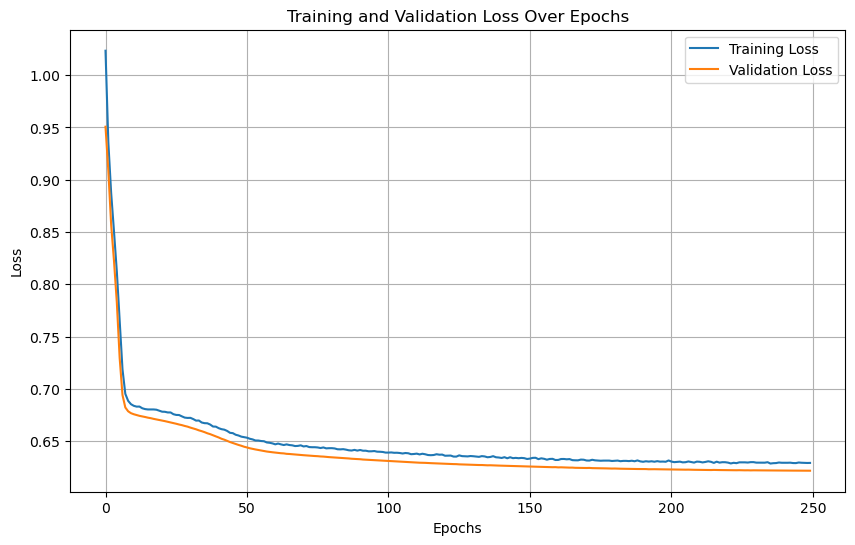

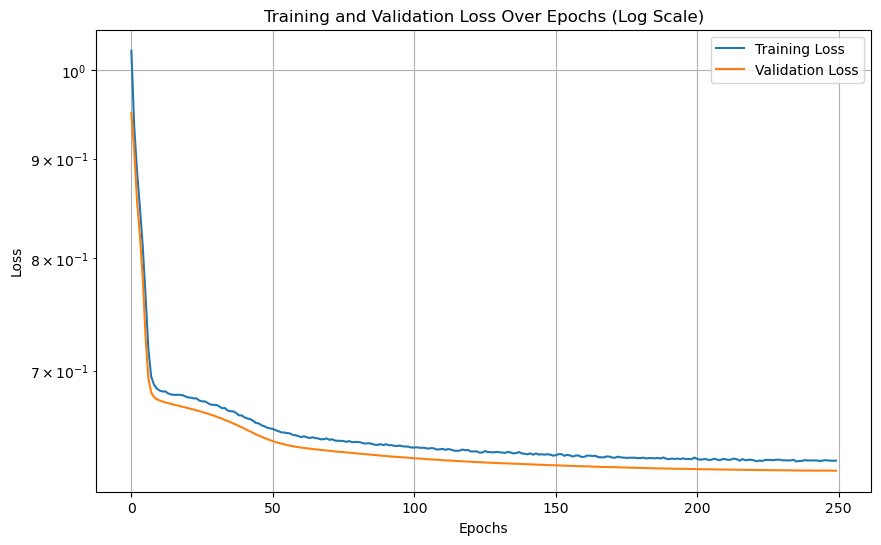

Epoch 251/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.87 batches/s]


Epoch [251/1000] - Train Loss: 0.6292, Val Loss: 0.6217


Epoch 252/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.82 batches/s]


Epoch [252/1000] - Train Loss: 0.6293, Val Loss: 0.6218


Epoch 253/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [253/1000] - Train Loss: 0.6293, Val Loss: 0.6218


Epoch 254/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.33 batches/s]


Epoch [254/1000] - Train Loss: 0.6292, Val Loss: 0.6216


Epoch 255/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.16 batches/s]


Epoch [255/1000] - Train Loss: 0.6286, Val Loss: 0.6216


Epoch 256/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.18 batches/s]


Epoch [256/1000] - Train Loss: 0.6290, Val Loss: 0.6217


Epoch 257/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.51 batches/s]


Epoch [257/1000] - Train Loss: 0.6292, Val Loss: 0.6216


Epoch 258/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.89 batches/s]


Epoch [258/1000] - Train Loss: 0.6288, Val Loss: 0.6215


Epoch 259/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.11 batches/s]


Epoch [259/1000] - Train Loss: 0.6288, Val Loss: 0.6216


Epoch 260/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.79 batches/s]


Epoch [260/1000] - Train Loss: 0.6287, Val Loss: 0.6215


Epoch 261/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  7.29 batches/s]


Epoch [261/1000] - Train Loss: 0.6296, Val Loss: 0.6216


Epoch 262/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.45 batches/s]


Epoch [262/1000] - Train Loss: 0.6288, Val Loss: 0.6215


Epoch 263/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.21 batches/s]


Epoch [263/1000] - Train Loss: 0.6290, Val Loss: 0.6215


Epoch 264/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.77 batches/s]


Epoch [264/1000] - Train Loss: 0.6288, Val Loss: 0.6216


Epoch 265/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.38 batches/s]


Epoch [265/1000] - Train Loss: 0.6288, Val Loss: 0.6215


Epoch 266/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.82 batches/s]


Epoch [266/1000] - Train Loss: 0.6294, Val Loss: 0.6215


Epoch 267/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.83 batches/s]


Epoch [267/1000] - Train Loss: 0.6292, Val Loss: 0.6214


Epoch 268/1000 - Training: 100%|██████████| 13/13 [00:01<00:00,  6.86 batches/s]


Epoch [268/1000] - Train Loss: 0.6290, Val Loss: 0.6215


Epoch 269/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.05 batches/s]


Epoch [269/1000] - Train Loss: 0.6288, Val Loss: 0.6215


Epoch 270/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.02 batches/s]


Epoch [270/1000] - Train Loss: 0.6288, Val Loss: 0.6215


Epoch 271/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.59 batches/s]


Epoch [271/1000] - Train Loss: 0.6288, Val Loss: 0.6214


Epoch 272/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  6.18 batches/s]


Epoch [272/1000] - Train Loss: 0.6291, Val Loss: 0.6214


Epoch 273/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.49 batches/s]


Epoch [273/1000] - Train Loss: 0.6288, Val Loss: 0.6214


Epoch 274/1000 - Training: 100%|██████████| 13/13 [00:02<00:00,  5.54 batches/s]


Epoch [274/1000] - Train Loss: 0.6287, Val Loss: 0.6213


Epoch 275/1000 - Training:  23%|██▎       | 3/13 [00:00<00:01,  6.22 batches/s]

In [ ]:

#################################
# Training the ConvRBM
#################################
# Instantiate ConvRBM

conv_rbm = ConvRBM(
    visible_channels=VISIBLE_CHANNELS,
    hidden_channels=HIDDEN_CHANNELS,
    kernel_size=KERNEL_SIZE,
    learning_rate=LEARNING_RATE,
    cd_k=CD_K,
    batch_size=BATCH_SIZE  # Ensure batch size is passed
).to(DEVICE)

# Train the ConvRBM
conv_rbm.train_rbm(
    train_loader, 
    val_loader,
    epochs=1000, 
    device=DEVICE,
    save_interval=25)

In [269]:
#################################
# Feature Extraction using ConvRBM
#################################
# load the saved model weights
conv_rbm.load_state_dict(torch.load('./model_weights/rbm_epoch_125.pth'))
conv_rbm.eval()
train_features = []
test_features = []

with torch.no_grad():
    for train_X, _ in train_loader: 
        train_X = train_X.to(DEVICE)
        f = conv_rbm.transform(train_X)
        train_features.append(f.cpu().numpy())
    for test_X, _ in test_loader:
        test_X = test_X.to(DEVICE)
        f = conv_rbm.transform(test_X)
        test_features.append(f.cpu().numpy())

train_features = np.concatenate(train_features, axis=0)
test_features = np.concatenate(test_features, axis=0)


In [270]:
#################################
# Classification
#################################
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np

# Extract labels for the train and test datasets
train_labels = []
test_labels = []

for _, label in train_loader.dataset:
    train_labels.append(label)

for _, label in test_loader.dataset:
    test_labels.append(label)

train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Train an SVM model
svm_clf = SVC(kernel='rbf', C=1.0, decision_function_shape='ovr')  # Using RBF kernel; you can try others like 'linear' or 'poly'
svm_clf.fit(train_features, train_labels)

# Predict on the test set
y_pred = svm_clf.predict(test_features)

# Calculate accuracy
acc = accuracy_score(test_labels, y_pred)

print(f"Test Accuracy: {acc:.4f}")

Test Accuracy: 0.1000
